In [28]:
!pip install cartopy

In [58]:
!pip install matplotlib cartopy imageio

In [59]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import imageio
import os

In [60]:
capitales = [
    ("Aguascalientes", 21.8823, -102.2826),
    ("Mexicali", 32.6245, -115.4523),
    ("La Paz", 24.1426, -110.3128),
    ("Campeche", 19.8301, -90.5349),
    ("Tuxtla Gutiérrez", 16.7510, -93.1160),
    ("Chihuahua", 28.6353, -106.0889),
    ("Saltillo", 25.4386, -100.9992),
    ("Colima", 19.2452, -103.7241),
    ("Durango", 24.0277, -104.6532),
    ("Guanajuato", 21.0190, -101.2574),
    ("Chilpancingo", 17.5515, -99.5058),
    ("Pachuca", 20.1011, -98.7591),
    ("Guadalajara", 20.6597, -103.3496),
    ("Toluca", 19.2826, -99.6557),
    ("Morelia", 19.7036, -101.2169),
    ("Cuernavaca", 18.9261, -99.2308),
    ("Tepic", 21.5085, -104.8957),
    ("Monterrey", 25.6866, -100.3161),
    ("Oaxaca de Juárez", 17.0732, -96.7266),
    ("Puebla", 19.0414, -98.2063),
    ("Santiago de Querétaro", 20.5888, -100.3899),
    ("Chetumal", 18.5000, -88.3000),
    ("San Luis Potosí", 22.1566, -100.9855),
    ("Culiacán", 24.8044, -107.4937),
    ("Hermosillo", 29.0729, -110.9559),
    ("Villahermosa", 17.9895, -92.9475),
    ("Ciudad Victoria", 23.7369, -99.1411),
    ("Tlaxcala", 19.3139, -98.2419),
    ("Xalapa", 19.5438, -96.9105),
    ("Mérida", 20.9674, -89.5926),
    ("Zacatecas", 22.7709, -102.5832)
]


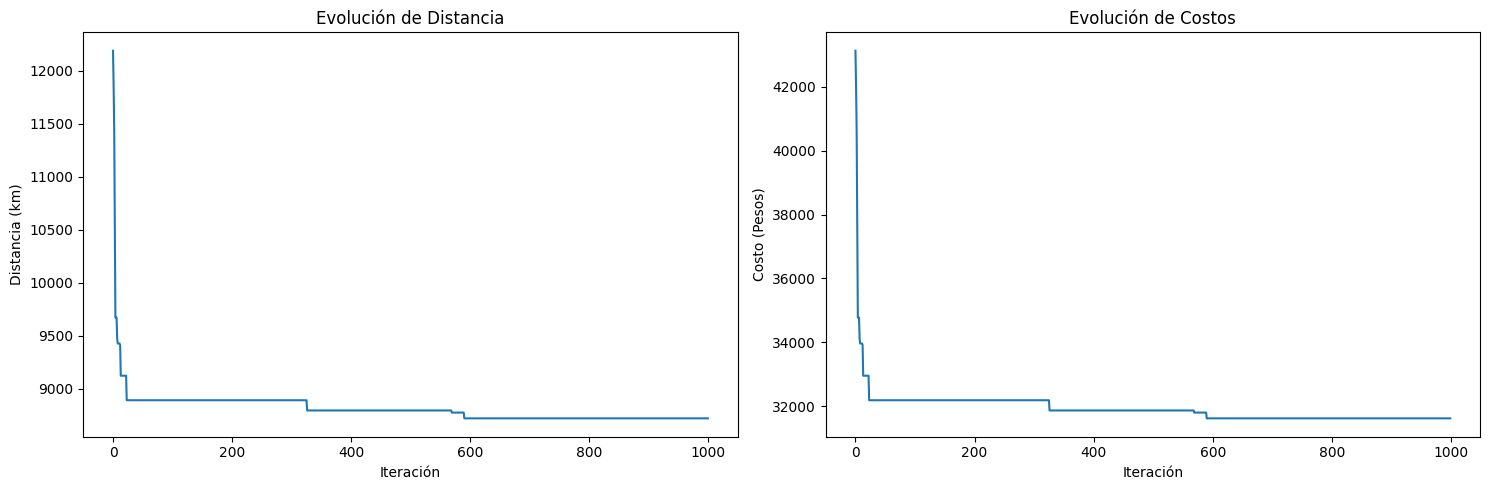

Mejor Ruta:
Chetumal
Mérida
Campeche
Villahermosa
Tuxtla Gutiérrez
Oaxaca de Juárez
Chilpancingo
Cuernavaca
Toluca
Morelia
Colima
Guadalajara
Tepic
Durango
Culiacán
La Paz
Hermosillo
Mexicali
Chihuahua
Saltillo
Monterrey
Ciudad Victoria
San Luis Potosí
Zacatecas
Aguascalientes
Guanajuato
Santiago de Querétaro
Pachuca
Tlaxcala
Puebla
Xalapa
Chetumal

Distancia Total: 8721.83 km
Costo Total: $31624.39 pesos
[21, 29, 3, 25, 4, 18, 10, 15, 13, 14, 7, 12, 16, 8, 23, 2, 24, 1, 5, 6, 17, 26, 22, 30, 0, 9, 20, 11, 27, 19, 28, 21]


In [61]:
class AntColonyTSP:
    def __init__(self, cities, coordinates):
        self.cities = cities
        self.coordinates = coordinates
        self.n_cities = len(cities)

        self.distance_matrix = self.calculate_distance_matrix()

        self.n_ants = 100
        self.n_iterations = 1000
        self.alpha = 1  # Importancia de feromonas
        self.beta = 2   # Importancia de la distancia
        self.evaporation_rate = 0.5
        self.Q = 100    # Constante de depósito de feromonas

        # Inicialización de feromonas
        self.pheromones = np.ones((self.n_cities, self.n_cities))

        # Costos de viaje
        self.hora_vendedor = 37  # pesos
        self.peaje = 87  # pesos
        self.costo_combustible = 27  # pesos por litro

    def haversine_distance(self, coord1, coord2):
        """Calcular distancia en kilómetros entre dos coordenadas"""
        R = 6371  # Radio de la Tierra en kilómetros
        lat1, lon1 = np.radians(coord1)
        lat2, lon2 = np.radians(coord2)

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

        return R * c

    def calculate_distance_matrix(self):
        """Crear matriz de distancias entre ciudades"""
        matrix = np.zeros((self.n_cities, self.n_cities))
        for i in range(self.n_cities):
            for j in range(self.n_cities):
                matrix[i][j] = self.haversine_distance(
                    self.coordinates[i][1:],
                    self.coordinates[j][1:]
                )
        return matrix

    def calculate_total_cost(self, route):
        """Calcular costo total de la ruta"""
        total_distance = sum(
            self.distance_matrix[route[i]][route[i+1]]
            for i in range(len(route)-1)
        )

        # Calcular costos adicionales
        costo_hora = self.hora_vendedor * (total_distance / 60)  # Asumiendo 60 km/h
        costo_peajes = self.peaje * (len(route) - 1)  # Peajes para cada tramo
        costo_combustible = self.costo_combustible * (total_distance / 10)  # Asumiendo 10 km/litro

        return total_distance, costo_hora + costo_peajes + costo_combustible

    def ant_colony_optimization(self):
        """Algoritmo de Colonias de Hormigas para TSP"""
        best_route = None
        best_distance = float('inf')
        best_cost = float('inf')

        distances_history = []
        costs_history = []

        for iteration in range(self.n_iterations):
            routes = []
            route_distances = []
            route_costs = []

            for _ in range(self.n_ants):
                route = self.construct_route()
                distance, cost = self.calculate_total_cost(route)

                routes.append(route)
                route_distances.append(distance)
                route_costs.append(cost)

                if cost < best_cost:
                    best_route = route
                    best_distance = distance
                    best_cost = cost

            distances_history.append(best_distance)
            costs_history.append(best_cost)

            self.update_pheromones(routes, route_costs)

        return best_route, best_distance, best_cost, distances_history, costs_history

    def construct_route(self):
        """Construir una ruta para una hormiga"""
        unvisited = list(range(self.n_cities))
        route = [unvisited.pop(np.random.randint(len(unvisited)))]

        while unvisited:
            current_city = route[-1]
            probabilities = self.calculate_probabilities(current_city, unvisited)
            next_city = np.random.choice(unvisited, p=probabilities)

            route.append(next_city)
            unvisited.remove(next_city)

        # Regresar a la ciudad inicial
        route.append(route[0])
        return route

    def calculate_probabilities(self, current_city, unvisited):
        """Calcular probabilidades de transición"""
        probabilities = []
        for city in unvisited:
            pheromone = self.pheromones[current_city][city]
            distance = self.distance_matrix[current_city][city]

            prob = (pheromone ** self.alpha) * ((1/distance) ** self.beta)
            probabilities.append(prob)

        probabilities = np.array(probabilities)
        return probabilities / probabilities.sum()

    def update_pheromones(self, routes, costs):
        """Actualizar rastros de feromonas"""
        self.pheromones *= (1 - self.evaporation_rate)

        for route, cost in zip(routes, costs):
            for i in range(len(route)-1):
                self.pheromones[route[i]][route[i+1]] += self.Q / cost
                self.pheromones[route[i+1]][route[i]] += self.Q / cost


# Nombres de capitales
nombres = [capital[0] for capital in capitales]

# Inicializar y ejecutar optimización
tsp = AntColonyTSP(nombres, capitales)
mejor_ruta_Ant, mejor_distancia, mejor_costo, distancias_historia, costos_historia = tsp.ant_colony_optimization()

# Visualizaciones
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(distancias_historia)
plt.title('Evolución de Distancia')
plt.xlabel('Iteración')
plt.ylabel('Distancia (km)')

plt.subplot(1, 2, 2)
plt.plot(costos_historia)
plt.title('Evolución de Costos')
plt.xlabel('Iteración')
plt.ylabel('Costo (Pesos)')

plt.tight_layout()
plt.show()

# Imprimir resultados
print("Mejor Ruta:")
for ciudad in mejor_ruta_Ant:
    print(nombres[ciudad])
print(f"\nDistancia Total: {mejor_distancia:.2f} km")
print(f"Costo Total: ${mejor_costo:.2f} pesos")
print(mejor_ruta_Ant)

In [62]:
coords = [(lat, lon) for _, lat, lon in capitales]
city_names = [name for name, _, _ in capitales]

# Ejemplo: Ruta óptima simulada (tu algoritmo debería generarla)
optimal_route = mejor_ruta_Ant
frames = []

# Crear los mapas paso a paso
for step in range(1, len(optimal_route)):
    fig, ax = plt.subplots(figsize=(60, 30), subplot_kw={'projection': ccrs.PlateCarree()})  # Tamaño más grande
    ax.set_extent([-120, -85, 15, 35], crs=ccrs.PlateCarree())

    # Agregar características de mapa
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, linestyle='--')

    # Dibujar las ciudades
    for i, (lat, lon) in enumerate(coords):
        ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree(), markersize=16)  # Tamaño más grande
        ax.text(lon + 0.5, lat, city_names[i], transform=ccrs.PlateCarree(), fontsize=24)  # Texto más grande

    # Dibujar las líneas del recorrido actual
    for i in range(step):
        start = optimal_route[i]
        end = optimal_route[i + 1]
        lat_start, lon_start = coords[start]
        lat_end, lon_end = coords[end]
        ax.plot([lon_start, lon_end], [lat_start, lat_end], 'b-', transform=ccrs.PlateCarree())

    # Guardar cada frame
    frame_filename = f"frame_{step}.png"
    plt.title(f"Paso {step}")
    plt.savefig(frame_filename)
    frames.append(frame_filename)
    plt.close()

# Crear el GIF
gif_filename = 'optimal_Ants.gif'
with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)

# Eliminar los archivos .png creados
for frame in frames:
    if os.path.exists(frame):
        os.remove(frame)

<ipython-input-62-51736d4a058a>:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


In [34]:
!pip install numpy matplotlib deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00


In [63]:
from typing import List, Tuple
import numpy as np
from scipy.spatial.distance import pdist, squareform
import random
from scipy.spatial import ConvexHull
import imageio

In [74]:
class GA_TSP:
    def __init__(self, cities: List[Tuple[str, float, float]],
                 population_size: int = 500,
                 generations: int = 100,
                 mutation_rate: float = 0.15,
                 edge_weight: float = 0.3,
                 hora_vendedor: float = 37,  # pesos
                 peaje: float = 87,  # pesos
                 costo_combustible: float = 27):
        self.capitales = cities
        self.city_names = [city[0] for city in cities]
        self.coords = np.array([(city[1], city[2]) for city in cities])
        self.n_cities = len(cities)
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.edge_weight = edge_weight

        # New cost parameters
        self.hora_vendedor = hora_vendedor
        self.peaje = peaje
        self.costo_combustible = costo_combustible

        self.distances = squareform(pdist(self.coords))
        self.border_edges = self._identify_border_edges()



    def _identify_border_edges(self) -> List[Tuple[int, int]]:
        border_edges = []
        for i in range(self.n_cities):
            for j in range(i+1, self.n_cities):
                distance = self.distances[i][j]
                angle_factor = self._calculate_edge_attractiveness(i, j)
                if distance < np.percentile(self.distances, 30) and angle_factor > 0.7:
                    border_edges.append((i, j))
        return border_edges

    def _calculate_edge_attractiveness(self, city1: int, city2: int) -> float:
        x1, y1 = self.coords[city1]
        x2, y2 = self.coords[city2]

        angle = np.arctan2(y2 - y1, x2 - x1)
        return abs(np.cos(angle))

    def calculate_cost(self, route: List[int], origin_city: int = 0) -> float:
        total_distance = 0
        border_bonus = 0
        additional_costs = 0

        if route[0] != origin_city:
            route = [origin_city] + [city for city in route if city != origin_city]

        for i in range(len(route)):
            current_city = route[i]
            next_city = route[(i + 1) % len(route)]

            # Distance cost
            total_distance += self.distances[current_city][next_city]

            # Border edge bonus
            if (current_city, next_city) in self.border_edges or \
              (next_city, current_city) in self.border_edges:
                border_bonus -= self.edge_weight


            if i > 0:
                time = self.distances[current_city][next_city] / 60  # Tiempo en horas a 60 km/h
                additional_costs += self.hora_vendedor * time

                additional_costs += self.peaje

                additional_costs += self.costo_combustible * self.distances[current_city][next_city] / 10

        return total_distance + border_bonus + additional_costs

    def create_population(self) -> List[List[int]]:

        population = []
        for _ in range(self.population_size):
            if random.random() < 0.5:
                route = random.sample(range(self.n_cities), self.n_cities)
            else:
                route = list(range(self.n_cities))
                random.shuffle(route)
                for edge in self.border_edges:
                    if edge[0] in route and edge[1] in route:
                        idx1 = route.index(edge[0])
                        idx2 = route.index(edge[1])
                        route[idx1], route[idx2] = route[idx2], route[idx1]
            population.append(route)
        return population

    def crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        start, end = sorted(random.sample(range(self.n_cities), 2))
        child = [-1] * self.n_cities
        child[start:end] = parent1[start:end]
        border_crossover = [city for city in parent2
                            if city not in child and
                            any((city, other) in self.border_edges or
                                (other, city) in self.border_edges
                                for other in child if other != -1)]

        idx = end
        for city in parent2 + border_crossover:
            if city not in child:
                while child[idx % self.n_cities] != -1:
                    idx += 1
                child[idx % self.n_cities] = city

        return child

    def mutate(self, route: List[int]) -> List[int]:
        if random.random() < self.mutation_rate:
            mutation_type = random.choice(['swap', 'reverse', 'border_prioritize'])

            if mutation_type == 'swap':

                i, j = random.sample(range(self.n_cities), 2)
                route[i], route[j] = route[j], route[i]

            elif mutation_type == 'reverse':

                start, end = sorted(random.sample(range(self.n_cities), 2))
                route[start:end] = route[start:end][::-1]

            elif mutation_type == 'border_prioritize':

                for edge in self.border_edges:
                    if edge[0] in route and edge[1] in route:
                        idx1, idx2 = route.index(edge[0]), route.index(edge[1])
                        route[idx1], route[idx2] = route[idx2], route[idx1]

        return route

    def solve(self, origin_city: int = 0) -> Tuple[List[int], float, List[str]]:
          population = self.create_population()
          best_route, best_cost = None, float('inf')

          for generation in range(self.generations):
              population = self.evolve_population(population)

              # Check cost for each route starting from origin city
              current_best = min(population, key=lambda route: self.calculate_cost(route, origin_city))
              current_cost = self.calculate_cost(current_best, origin_city)

              if current_cost < best_cost:
                  best_route, best_cost = current_best, current_cost

              if generation % 10 == 0:
                  self.mutation_rate *= 0.95

          # Convert route indices to city names, ensuring origin is first
          best_route_names = [self.city_names[city] for city in best_route]
          best_route_names = best_route_names[best_route_names.index(self.city_names[origin_city]):] + \
                              best_route_names[:best_route_names.index(self.city_names[origin_city])]

          return best_route, best_cost, best_route_names

    def evolve_population(self, population: List[List[int]]) -> List[List[int]]:
        sorted_population = sorted(population, key=self.calculate_cost)
        elite_count = self.population_size // 4
        next_generation = sorted_population[:elite_count]

        while len(next_generation) < self.population_size:
            parent1, parent2 = random.choices(sorted_population[:elite_count*2], k=2)
            child = self.crossover(parent1, parent2)
            child = self.mutate(child)
            next_generation.append(child)

        return next_generation

In [75]:
# Resolver con GA
ga_solver = GA_TSP(capitales)
ga_route_indices, ga_cost, ga_route_names = ga_solver.solve()
print(f"GA: Mejor ruta: {ga_route_names}, Costo: {ga_cost:.2f}")

GA: Mejor ruta: ['Aguascalientes', 'Guadalajara', 'Tepic', 'Zacatecas', 'Durango', 'Culiacán', 'La Paz', 'Hermosillo', 'Mexicali', 'Chihuahua', 'Saltillo', 'Monterrey', 'Ciudad Victoria', 'San Luis Potosí', 'Guanajuato', 'Mérida', 'Campeche', 'Chetumal', 'Tuxtla Gutiérrez', 'Villahermosa', 'Oaxaca de Juárez', 'Chilpancingo', 'Cuernavaca', 'Pachuca', 'Tlaxcala', 'Puebla', 'Xalapa', 'Toluca', 'Santiago de Querétaro', 'Morelia', 'Colima'], Costo: 2962.19


In [76]:
import matplotlib.pyplot as plt
coords = [(lat, lon) for _, lat, lon in capitales]
city_names = [name for name, _, _ in capitales]

# Ejemplo: Ruta óptima simulada (tu algoritmo debería generarla)
optimal_route = ga_route_indices
frames = []

# Crear los mapas paso a paso
for step in range(1, len(optimal_route)):
    fig, ax = plt.subplots(figsize=(60, 30), subplot_kw={'projection': ccrs.PlateCarree()})  # Tamaño más grande
    ax.set_extent([-120, -85, 15, 35], crs=ccrs.PlateCarree())

    # Agregar características de mapa
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, linestyle='--')

    # Dibujar las ciudades
    for i, (lat, lon) in enumerate(coords):
        ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree(), markersize=16)  # Tamaño más grande
        ax.text(lon + 0.5, lat, city_names[i], transform=ccrs.PlateCarree(), fontsize=24)  # Texto más grande

    # Dibujar las líneas del recorrido actual
    for i in range(step):
        start = optimal_route[i]
        end = optimal_route[i + 1]
        lat_start, lon_start = coords[start]
        lat_end, lon_end = coords[end]
        ax.plot([lon_start, lon_end], [lat_start, lat_end], 'b-', transform=ccrs.PlateCarree())

    # Guardar cada frame
    frame_filename = f"frame_{step}.png"
    plt.title(f"Paso {step}")
    plt.savefig(frame_filename)
    frames.append(frame_filename)
    plt.close()

# Crear el GIF
gif_filename = 'optimal_Gen.gif'
with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)

# Eliminar los archivos .png creados
for frame in frames:
    if os.path.exists(frame):
        os.remove(frame)

<ipython-input-76-7ab2f34b4bbb>:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)
